In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Hold-out
from sklearn.model_selection import train_test_split

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
# Optional: KNN
from sklearn.neighbors import KNeighborsClassifier

##### Decision Tree Visualization ###
#from sklearn.tree import export_graphviz
from sklearn import tree # export_graphviz() method
import pydotplus # viz stuff
from IPython.display import Image # viz stuff
from sklearn.ensemble import RandomForestClassifier
####################################

######## Evaluation #######
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn import linear_model
from sklearn.svm import SVC

from sklearn.metrics import RocCurveDisplay

# Optional: baseline comparison
from sklearn.dummy import DummyClassifier
###########################

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# cross-validation
from sklearn.model_selection import cross_val_score

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import zero_one_loss
from sklearn.neighbors import KNeighborsClassifier

from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

from sklearn.manifold import TSNE

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
features = list()
with open('../features.txt') as f:
    features = [line.split()[1] for line in f.readlines()]
print('No of Features: {}'.format(len(features)))

No of Features: 561


In [4]:
X_train = pd.read_csv('X_train.txt', delim_whitespace=True, header=None, encoding='latin-1')
X_train.columns = features

# add subject column to the dataframe
X_train['subject'] = pd.read_csv('subject_train.txt', header=None, squeeze=True)

y_train = pd.read_csv('y_train.txt', names=['Activity'], squeeze=True)
y_train_labels = y_train.map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',\
                       4:'SITTING', 5:'STANDING',6:'LAYING'})

# put all columns in a single dataframe
train = X_train
train['Activity'] = y_train
train['ActivityName'] = y_train_labels

In [5]:
X_test = pd.read_csv('../test/X_test.txt', delim_whitespace=True, header=None, encoding='latin-1')
X_test.columns = features

# add subject column to the dataframe
X_test['subject'] = pd.read_csv('../test/subject_test.txt', header=None, squeeze=True)

y_test = pd.read_csv('../test/y_test.txt', names=['Activity'], squeeze=True)
y_test_labels = y_test.map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',\
                       4:'SITTING', 5:'STANDING',6:'LAYING'})

# put all columns in a single dataframe
test = X_test
test['Activity'] = y_test
test['ActivityName'] = y_test_labels

In [6]:
from collections import Counter
print(Counter(y_train))

Counter({6: 1407, 5: 1374, 4: 1286, 1: 1226, 2: 1073, 3: 986})


In [7]:
np.unique(y_train, return_counts=True)

(array([1, 2, 3, 4, 5, 6]), array([1226, 1073,  986, 1286, 1374, 1407]))

# Class preparations

In [8]:
sitting_train = []
for i in range(len(X_train)):
    if X_train.iloc[i][563] == 'SITTING':
        sitting_train.append(i)

standing_train = []
for i in range(len(X_train)):
    if X_train.iloc[i][563] == 'STANDING':
        standing_train.append(i)
        
laying_train = []
for i in range(len(X_train)):
    if X_train.iloc[i][563] == 'LAYING':
        laying_train.append(i)

In [9]:
sitting_test = []
for i in range(len(X_test)):
    if X_test.iloc[i][563] == 'SITTING':
        sitting_test.append(i)

standing_test = []
for i in range(len(X_test)):
    if X_test.iloc[i][563] == 'STANDING':
        standing_test.append(i)
        
laying_test = []
for i in range(len(X_test)):
    if X_test.iloc[i][563] == 'LAYING':
        laying_test.append(i)

In [10]:
droptrian = sitting_train + standing_train + laying_train

In [11]:
droptest =sitting_test + standing_test + laying_test

In [12]:
X_train_sbilanciato = X_train.drop(droptrian)

In [13]:
X_test_sbilanciato = X_test.drop(droptest)

In [14]:
X_train_sbilanciato = X_train_sbilanciato.drop(columns=['Activity'])

In [15]:
X_test_sbilanciato = X_test_sbilanciato.drop(columns=['Activity'])

In [16]:
tmp = []
for i in range(len(y_train)):
    if y_train[i] == 1 or y_train[i] == 2 or y_train[i] == 3:
        tmp.append(y_train[i])
y_train_sbilanciato = pd.Series(tmp, copy=False)

In [17]:
tmp = []
for i in range(len(y_test)):
    if y_test[i] == 1 or y_test[i] == 2 or y_test[i] == 3:
        tmp.append(y_test[i])
y_test_sbilanciato = pd.Series(tmp, copy=False)

In [18]:
print(Counter(y_train_sbilanciato))

Counter({1: 1226, 2: 1073, 3: 986})


In [19]:
print(Counter(y_test_sbilanciato))

Counter({1: 496, 2: 471, 3: 420})


In [20]:
np.where(y_train_sbilanciato.index.isnull())

(array([], dtype=int64),)

In [21]:
X_train_sbilanciato = X_train_sbilanciato.drop(['ActivityName'], axis=1)

In [22]:
X_test_sbilanciato = X_test_sbilanciato.drop(['ActivityName'], axis=1)

# First class train

In [23]:
rows2remove = np.random.choice(np.arange(len(y_train_sbilanciato))[y_train_sbilanciato.values == 1], 1226 - 200, replace=False)

In [24]:
len(X_train_sbilanciato), len(rows2remove)

(3285, 1026)

In [25]:
train_sbilanciato = X_train_sbilanciato.drop(X_train_sbilanciato.index[rows2remove])

In [26]:
X1_train_sbilanciato = train_sbilanciato.values
y1_train_sbilanciato = np.array([y_train_sbilanciato[i] for i in range(len(y_train_sbilanciato)) if i not in rows2remove])

In [27]:
len(X1_train_sbilanciato), len(train_sbilanciato)

(2259, 2259)

In [28]:
print(Counter(y1_train_sbilanciato))

Counter({2: 1073, 3: 986, 1: 200})


In [29]:
np.unique(y1_train_sbilanciato, return_counts=True)

(array([1, 2, 3]), array([ 200, 1073,  986]))

In [30]:
y1_train_sbilanciato = pd.Series(y1_train_sbilanciato, copy=False)

# Second class train

In [31]:
rows2remove = np.random.choice(np.arange(len(y1_train_sbilanciato))[y1_train_sbilanciato.values == 2], 1073 - 9, replace=False)

In [32]:
len(X1_train_sbilanciato), len(rows2remove), len(y1_train_sbilanciato)

(2259, 1064, 2259)

In [33]:
train_sbilanciato2 = train_sbilanciato.drop(train_sbilanciato.index[rows2remove])

In [34]:
X2_train_sbilanciato2 = train_sbilanciato2.values
y2_train_sbilanciato2 = np.array([y1_train_sbilanciato[i] for i in range(len(y1_train_sbilanciato)) if i not in rows2remove])

In [35]:
len(X2_train_sbilanciato2), len(y2_train_sbilanciato2)

(1195, 1195)

In [36]:
np.unique(y2_train_sbilanciato2, return_counts=True)

(array([1, 2, 3]), array([200,   9, 986]))

# First class test

In [37]:
rows2remove = np.random.choice(np.arange(len(y_test_sbilanciato))[y_test_sbilanciato.values == 1], 496 - 27, replace=False)

In [38]:
len(y_test_sbilanciato), len(rows2remove)

(1387, 469)

In [39]:
#y_train_sbilanciato.iloc[3039]

In [40]:
test_sbilanciato = X_test_sbilanciato.drop(X_test_sbilanciato.index[rows2remove])
#print(len(df1))

In [41]:
X1_test_sbilanciato = test_sbilanciato.values
y1_test_sbilanciato = np.array([y_test_sbilanciato[i] for i in range(len(y_test_sbilanciato)) if i not in rows2remove])

In [42]:
len(X1_test_sbilanciato), len(y1_test_sbilanciato)

(918, 918)

In [43]:
print(Counter(y1_test_sbilanciato))

Counter({2: 471, 3: 420, 1: 27})


In [44]:
np.unique(y1_test_sbilanciato, return_counts=True)

(array([1, 2, 3]), array([ 27, 471, 420]))

In [45]:
y1_test_sbilanciato = pd.Series(y1_test_sbilanciato, copy=False)

# Second class test

In [46]:
rows2remove = np.random.choice(np.arange(len(y1_test_sbilanciato))[y1_test_sbilanciato.values == 2], 471 - 50, replace=False)

In [47]:
len(X1_test_sbilanciato), len(rows2remove), len(y1_test_sbilanciato)

(918, 421, 918)

In [48]:
test_sbilanciato2 = test_sbilanciato.drop(test_sbilanciato.index[rows2remove], axis=0)
#print(len(df2))

In [49]:
X2_test_sbilanciato2 = test_sbilanciato2.values
y2_test_sbilanciato2 = np.array([y1_test_sbilanciato[i] for i in range(len(y1_test_sbilanciato)) if i not in rows2remove])

In [50]:
len(X2_test_sbilanciato2), len(test_sbilanciato2)

(497, 497)

In [51]:
np.unique(y2_test_sbilanciato2, return_counts=True)

(array([1, 2, 3]), array([ 27,  50, 420]))

In [52]:
New_Xtest = pd.DataFrame(X2_test_sbilanciato2)
New_Xtrain = pd.DataFrame(X2_train_sbilanciato2)

In [53]:
New_yTest = pd.Series(y2_test_sbilanciato2, copy=False)
New_yTrain = pd.Series(y2_train_sbilanciato2, copy=False)

# Grid search

# Decision tree

In [54]:
clf = DecisionTreeClassifier(criterion='entropy',
                             max_depth=None,
                             min_samples_split=2,
                             min_samples_leaf=1,
                            )

clf.fit(New_Xtrain, New_yTrain)

DecisionTreeClassifier(criterion='entropy')

In [55]:
y_pred = clf.predict(New_Xtest)

In [56]:
print( classification_report(New_yTest, y_pred) )

              precision    recall  f1-score   support

           1       0.39      0.78      0.52        27
           2       0.75      0.12      0.21        50
           3       0.94      0.97      0.95       420

    accuracy                           0.87       497
   macro avg       0.69      0.62      0.56       497
weighted avg       0.89      0.87      0.85       497



In [57]:
y_score = clf.predict_proba(New_Xtest)

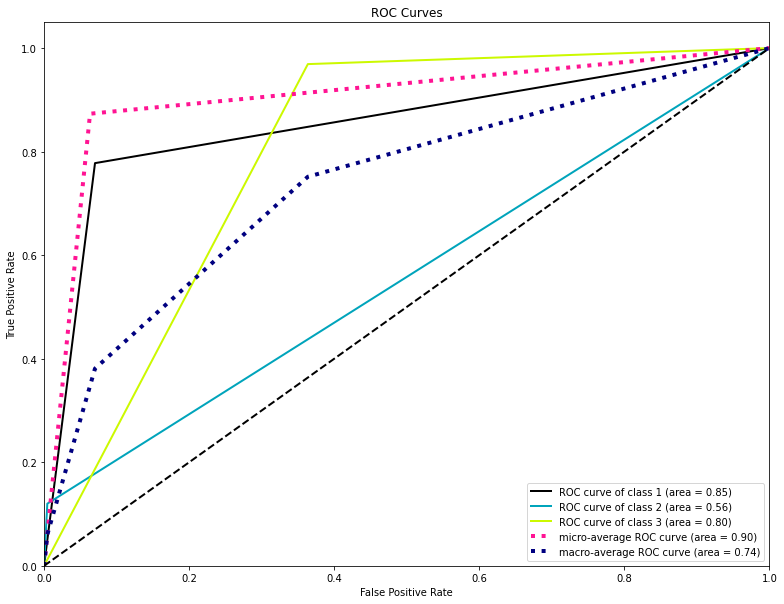

In [58]:
plot_roc(New_yTest, y_score, figsize=(13,10))
plt.show()

# k-NN

In [59]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(New_Xtrain, New_yTrain)

KNeighborsClassifier(n_neighbors=7)

In [60]:
y_pred_KNN = knn.predict(New_Xtest)

In [61]:
print(classification_report(New_yTest, y_pred_KNN))

              precision    recall  f1-score   support

           1       0.33      0.78      0.46        27
           2       0.00      0.00      0.00        50
           3       0.91      0.94      0.92       420

    accuracy                           0.83       497
   macro avg       0.41      0.57      0.46       497
weighted avg       0.78      0.83      0.80       497



In [62]:
y_score = knn.predict_proba(New_Xtest)

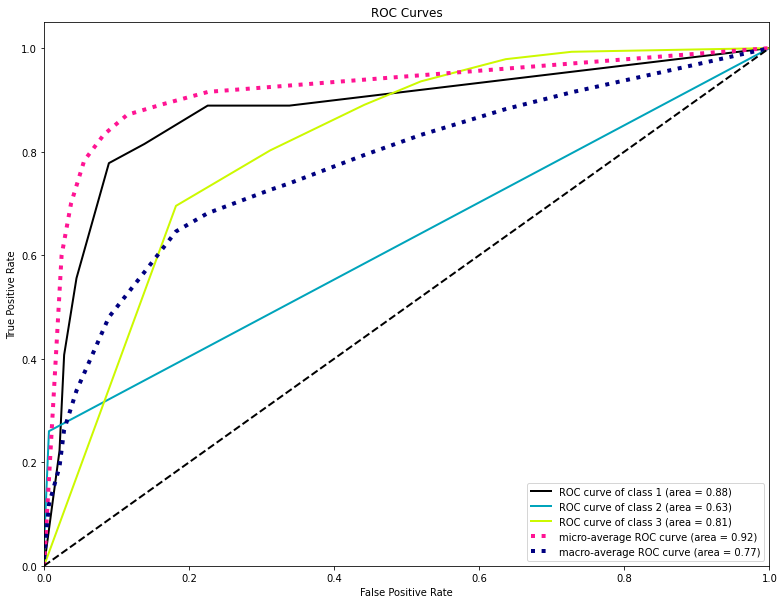

In [63]:
plot_roc(New_yTest, y_score, figsize=(13,10))
plt.show()

# Boosting

In [64]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [65]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=0)
clf.fit(New_Xtrain, New_yTrain)

y_pred_boost = clf.predict(New_Xtest)

print(classification_report(New_yTest, y_pred_boost))

              precision    recall  f1-score   support

           1       0.41      0.89      0.56        27
           2       0.69      0.18      0.29        50
           3       0.94      0.95      0.95       420

    accuracy                           0.87       497
   macro avg       0.68      0.67      0.60       497
weighted avg       0.89      0.87      0.86       497



In [67]:
clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(), n_estimators=100, random_state=0)
clf.fit(New_Xtrain, New_yTrain)

y_pred_boost = clf.predict(New_Xtest)

print(classification_report(New_yTest, y_pred_boost))

              precision    recall  f1-score   support

           1       0.40      0.93      0.56        27
           2       0.00      0.00      0.00        50
           3       0.94      0.97      0.96       420

    accuracy                           0.87       497
   macro avg       0.45      0.63      0.50       497
weighted avg       0.82      0.87      0.84       497

